In [1]:
import sys
import os
# Adds the project root directory to the Python path.
# The notebook is in 'Examples/pde', so we need to go up two levels
project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from pysymmetry import *
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import time
import pandas as pd
from scipy.sparse import diags

# --- Configuração de Gráficos para Qualidade de Publicação ---
font = {'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True) # Usar LaTeX para renderizar o texto
plt.rc('lines', linewidth=2.5, markersize=8)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--', alpha=0.6)

In [ ]:
# --- Funções Auxiliares ---
def generators2d(n):
    # Geradores para o grupo D4 na grade n x n
    string_reflexao_sigma = ''
    for j in range(1,(n/2+1).floor()):
        for k in range(0,n):
            string_reflexao_sigma = string_reflexao_sigma + str((k*n+j,k*n+n-j+1))
    
    string_reflexao_miDp = ''
    for i in range(1, n):
        for j in range(i+1, n+1):            
            string_reflexao_miDp = string_reflexao_miDp + str(((i-1)*n+j,(j-1)*n+i))
            
    return [string_reflexao_sigma, string_reflexao_miDp]

def calculate_block_eigenvalues(block):
    """Função auxiliar para cálculo paralelo de autovalores (complexos)."""
    return np.linalg.eigvals(block.toarray())



In [ ]:
num_runs = 5 
grid_sizes = np.array([60, 70, 80, 90])
matrix_dimensions = grid_sizes**2


    "preprocessing": [],
    "block_eigvals": [],
    "total_symmetry": [],
    "full_matrix": []
}

In [ ]:

V0_amplitude = 10.0


with Pool() as p:
    
    for n in grid_sizes:
        N = n**2
        print(f"Processing grid {n}x{n} (Matrix dimension: {N}x{N}) for {num_runs} runs...")       
        
        temp_preprocess = []
        temp_blocks = []
        temp_total_symm = []
        temp_full = []

        
        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs}...")
            
            start_time = time.perf_counter()
            M = schrodinger_complex_potential_2d(n, V0=V0_amplitude)
            G = nGroup(generators2d(ZZ(n)))
            gens = G.gens()
            img = [g.matrix() for g in gens]
            r = G.nrepresentation(gens, img)
            base = G.nbase_change_reduction(r)
            blocks = base.get_blocks(M)
            t_preprocessing = time.perf_counter() - start_time
            temp_preprocess.append(t_preprocessing)

            
            start_time = time.perf_counter()
            block_eigenvalues_list = p.map(calculate_block_eigenvalues, blocks)
            t_block_eigvals = time.perf_counter() - start_time
            temp_blocks.append(t_block_eigvals)
            
            total_sym_time = t_preprocessing + t_block_eigvals
            temp_total_symm.append(total_sym_time)

            
            start_time = time.perf_counter()
            full_eigenvalues = np.linalg.eigvals(M.toarray())
            t_full = time.perf_counter() - start_time
            temp_full.append(t_full)

        raw_timings["preprocessing"].append(temp_preprocess)
        raw_timings["block_eigvals"].append(temp_blocks)
        raw_timings["total_symmetry"].append(temp_total_symm)
        raw_timings["full_matrix"].append(temp_full)
        print(f"Finished processing for grid {n}x{n}.\n")

print("Performance analysis complete.")

Processing grid 60x60 (Matrix dimension: 3600x3600) for 5 runs...
  Run 1/5...
  Run 2/5...
  Run 3/5...
  Run 4/5...
  Run 5/5...
Finished processing for grid 60x60.

Processing grid 70x70 (Matrix dimension: 4900x4900) for 5 runs...
  Run 1/5...
  Run 2/5...
  Run 3/5...
  Run 4/5...
  Run 5/5...
Finished processing for grid 70x70.

Processing grid 80x80 (Matrix dimension: 6400x6400) for 5 runs...
  Run 1/5...
  Run 2/5...
  Run 3/5...
  Run 4/5...
  Run 5/5...
Finished processing for grid 80x80.

Processing grid 90x90 (Matrix dimension: 8100x8100) for 5 runs...
  Run 1/5...
  Run 2/5...
  Run 3/5...
  Run 4/5...
  Run 5/5...
Finished processing for grid 90x90.

Performance analysis complete.


--- Dados Detalhados para a Tabela LaTeX ---


,Grid Size,Matrix Dim (N),T_preprocess (s),T_blocks_eig (s),T_symmetry_total (s),T_full_matrix (s),Speedup
0,60x60,3600,5.10 \pm 0.35,1.23 \pm 0.17,6.33 \pm 0.50,46.98 \pm 2.83,7.47 \pm 0.77
1,70x70,4900,9.33 \pm 0.56,2.76 \pm 0.10,12.09 \pm 0.52,124.37 \pm 7.15,10.31 \pm 0.79
2,80x80,6400,15.79 \pm 0.63,5.36 \pm 0.14,21.16 \pm 0.58,301.29 \pm 3.51,14.25 \pm 0.49
3,90x90,8100,30.98 \pm 3.31,10.90 \pm 0.81,41.88 \pm 3.54,704.55 \pm 28.05,16.93 \pm 1.45


--- Performance Results (Schrödinger Problem, Avg of 5 runs) ---


,Grid Size,Matrix Dim (N),T_symmetry_total (s),T_full_matrix (s),Speedup
0,60x60,3600,6.33 ± 0.50,46.98 ± 2.83,7.47 ± 0.77
1,70x70,4900,12.09 ± 0.52,124.37 ± 7.15,10.31 ± 0.79
2,80x80,6400,21.16 ± 0.58,301.29 ± 3.51,14.25 ± 0.49
3,90x90,8100,41.88 ± 3.54,704.55 ± 28.05,16.93 ± 1.45


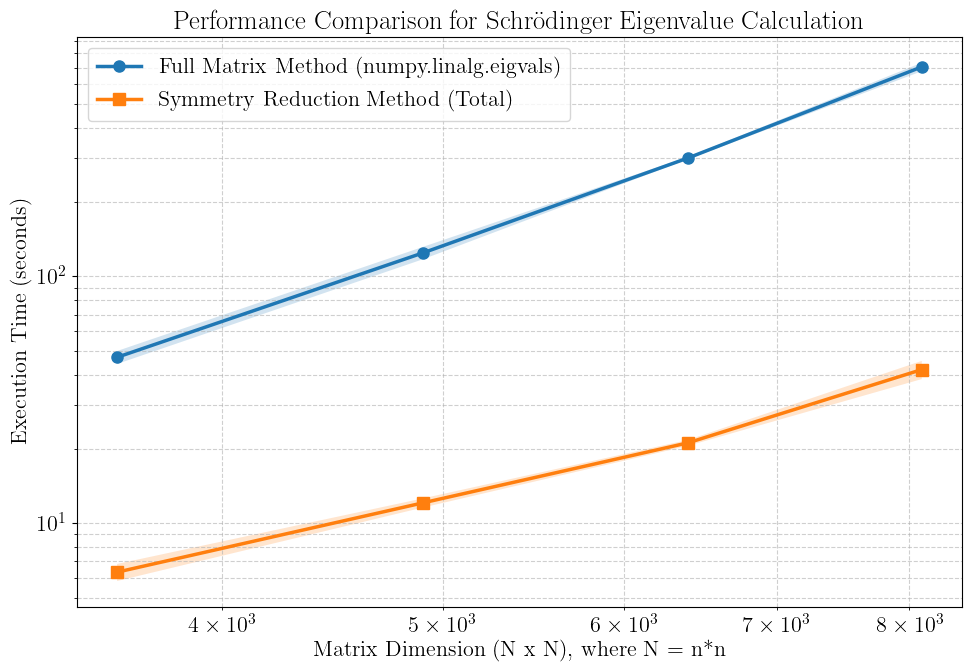

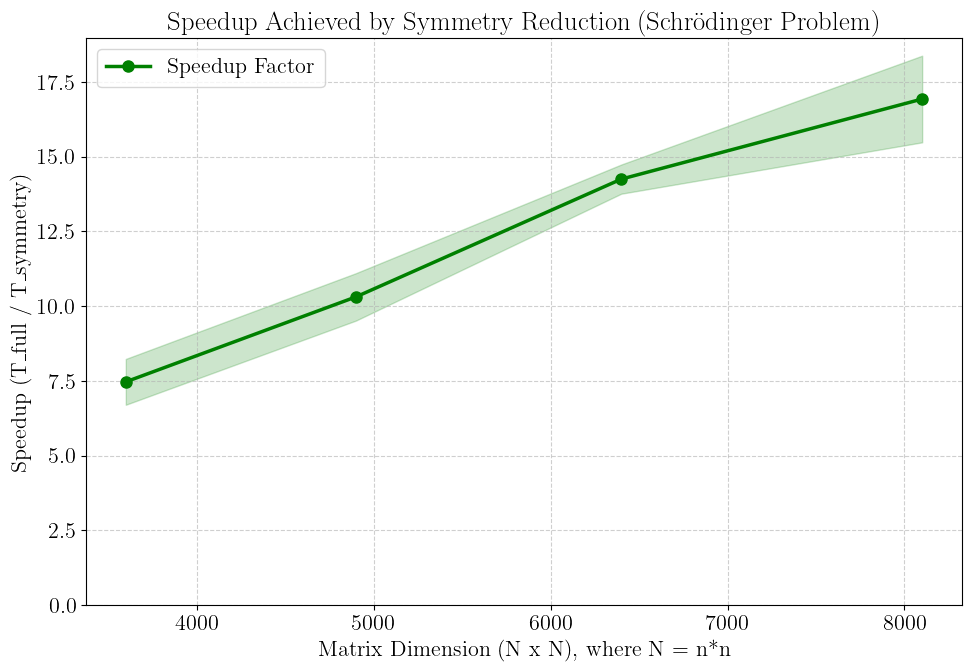

In [10]:
# --- 1. Processar os dados brutos para calcular média e desvio padrão ---
results = {}
for key, values_by_size in raw_timings.items():
    results[f'{key}_mean'] = [np.mean(runs) for runs in values_by_size]
    results[f'{key}_std'] = [np.std(runs) for runs in values_by_size]

# Calcular speedup e seu desvio padrão
total_symm_raw = np.array(raw_timings['total_symmetry'])
full_matrix_raw = np.array(raw_timings['full_matrix'])
speedup_raw = full_matrix_raw / total_symm_raw

results['speedup_mean'] = [np.mean(runs) for runs in speedup_raw]
results['speedup_std'] = [np.std(runs) for runs in speedup_raw]

# Adicione estas linhas à sua célula de criação do DataFrame
df_results_detailed = pd.DataFrame({
    'Grid Size': [f"{n}x{n}" for n in grid_sizes],
    'Matrix Dim (N)': matrix_dimensions,
    'T_preprocess (s)': [f"{mean:.2f} \\pm {std:.2f}" for mean, std in zip(results['preprocessing_mean'], results['preprocessing_std'])],
    'T_blocks_eig (s)': [f"{mean:.2f} \\pm {std:.2f}" for mean, std in zip(results['block_eigvals_mean'], results['block_eigvals_std'])],
    'T_symmetry_total (s)': [f"{mean:.2f} \\pm {std:.2f}" for mean, std in zip(results['total_symmetry_mean'], results['total_symmetry_std'])],
    'T_full_matrix (s)': [f"{mean:.2f} \\pm {std:.2f}" for mean, std in zip(results['full_matrix_mean'], results['full_matrix_std'])],
    'Speedup': [f"{mean:.2f} \\pm {std:.2f}" for mean, std in zip(results['speedup_mean'], results['speedup_std'])]
})

print("--- Dados Detalhados para a Tabela LaTeX ---")
display(df_results_detailed)
# --- 2. Criar DataFrame para exibição profissional ---
# Combinamos média e desvio padrão em uma única string para a tabela
df_results = pd.DataFrame({
    'Grid Size': [f"{n}x{n}" for n in grid_sizes],
    'Matrix Dim (N)': matrix_dimensions,
    'T_symmetry_total (s)': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(results['total_symmetry_mean'], results['total_symmetry_std'])],
    'T_full_matrix (s)': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(results['full_matrix_mean'], results['full_matrix_std'])],
    'Speedup': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(results['speedup_mean'], results['speedup_std'])]
})

print("--- Performance Results (Schrödinger Problem, Avg of {} runs) ---".format(num_runs))
display(df_results)


# --- 3. Gráfico 1: Log-Log com barras de erro (região sombreada) ---
fig, ax = plt.subplots(figsize=(10, 7))

# Plotar dados do método completo com sua variabilidade
mean = np.array(results['full_matrix_mean'])
std = np.array(results['full_matrix_std'])
ax.loglog(matrix_dimensions, mean, 'o-', label='Full Matrix Method (numpy.linalg.eigvals)')
ax.fill_between(matrix_dimensions, mean - std, mean + std, alpha=0.2)

# Plotar dados do método de simetria com sua variabilidade
mean_symm = np.array(results['total_symmetry_mean'])
std_symm = np.array(results['total_symmetry_std'])
ax.loglog(matrix_dimensions, mean_symm, 's-', label='Symmetry Reduction Method (Total)')
ax.fill_between(matrix_dimensions, mean_symm - std_symm, mean_symm + std_symm, alpha=0.2)

ax.set_xlabel('Matrix Dimension (N x N), where N = n*n')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Performance Comparison for Schrödinger Eigenvalue Calculation')
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


# --- 4. Gráfico 2: Speedup com barras de erro ---
fig2, ax2 = plt.subplots(figsize=(10, 7))
mean_speedup = np.array(results['speedup_mean'])
std_speedup = np.array(results['speedup_std'])
ax2.plot(matrix_dimensions, mean_speedup, 'o-', color='green', label='Speedup Factor')
ax2.fill_between(matrix_dimensions, mean_speedup - std_speedup, mean_speedup + std_speedup, color='green', alpha=0.2)

ax2.set_xlabel('Matrix Dimension (N x N), where N = n*n')
ax2.set_ylabel('Speedup (T_full / T_symmetry)')
ax2.set_title('Speedup Achieved by Symmetry Reduction (Schrödinger Problem)')
ax2.legend()
ax2.grid(True, which="both", ls="--")
ax2.set_ylim(bottom=0)
plt.tight_layout()
plt.show()